<a href="https://colab.research.google.com/github/ishancoderr/GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import os

**Buiding a Generator Model**

In [2]:
def build_generator(image_size=28, input_size=100):
    
    #Build an input layer
    gen_input = tf.keras.layers.Input(shape=(input_size,))
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x = tf.keras.layers.Dense(7 * 7 * 128)(gen_input)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    
    #Use ConvTranspose
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Output layer for Generator
    # for black and white layer
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    #Build model using Model API
    generator = tf.keras.models.Model(gen_input, x, name='generator')
    
    return generator

**Building a Discriminator**

In [3]:
def build_discriminator(data_shape=[28,28,1,]):
    
    #Build the network
    dis_input = tf.keras.layers.Input(data_shape)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(dis_input)
    x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Flatten the output and build an output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    #Build Model
    discriminator = tf.keras.models.Model(dis_input, x, name='discriminator')
    
    return discriminator

**Building Models for Training**

In [8]:
def build_models():
    
    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build Base Discriminator model
    base_discriminator = build_discriminator(data_shape=(28,28,1,))
    
    #Define optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = build_generator(image_size=28, input_size=noise_size)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

**Training Discriminator and Adversarial Mode**

In [9]:
def train_gan(generator, discriminator, adversarial, noise_size=100):
    
    #Training parameters
    batch_size = 64
    train_steps = 10000
    image_size = 28
    
    # load MNIST dataset
    (train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()
    #Make it 3D dataset
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])
    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size])
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        fake_images = generator.predict(noise_input)
        
        #2. Get real images from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        
        #3. Prepare input for training Discriminator
        X = np.concatenate((real_images, fake_images))
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch(X, y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X = noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1))
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial.train_on_batch(X, y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict(test_noise_input)
            
            #Display images
            plot_images(fake_images, i+1)
            
    #Save Generator model
    generator.save('mnist_generator_dcgan.h5')   

**Save generator images**

In [10]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(2.5,2.5))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

**Start GAN Training**

In [11]:
G, D, A = build_models()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                 

In [13]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928

In [14]:
A.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                   

11501568/11490434 [==============================] - 0s 0us/step
0 [Discriminator loss: 0.696958, acc: 0.273438, Adversarial loss: 0.969565, acc: 0.000000]
100 [Discriminator loss: 0.000048, acc: 1.000000, Adversarial loss: 0.000237, acc: 1.000000]
200 [Discriminator loss: 0.002334, acc: 1.000000, Adversarial loss: 0.021607, acc: 1.000000]
300 [Discriminator loss: 0.005106, acc: 1.000000, Adversarial loss: 0.000051, acc: 1.000000]
400 [Discriminator loss: 0.039852, acc: 1.000000, Adversarial loss: 0.451144, acc: 0.984375]


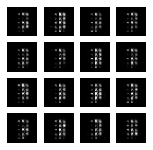

500 [Discriminator loss: 0.012544, acc: 1.000000, Adversarial loss: 0.067999, acc: 1.000000]
600 [Discriminator loss: 0.334109, acc: 0.843750, Adversarial loss: 0.379950, acc: 0.968750]
700 [Discriminator loss: 2.136269, acc: 0.539062, Adversarial loss: 0.118512, acc: 0.968750]
800 [Discriminator loss: 0.430522, acc: 0.804688, Adversarial loss: 0.000048, acc: 1.000000]
900 [Discriminator loss: 0.440155, acc: 0.781250, Adversarial loss: 0.940741, acc: 0.265625]


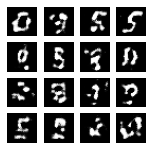

1000 [Discriminator loss: 0.513494, acc: 0.757812, Adversarial loss: 0.919159, acc: 0.265625]
1100 [Discriminator loss: 0.525855, acc: 0.781250, Adversarial loss: 0.904186, acc: 0.296875]
1200 [Discriminator loss: 0.501768, acc: 0.750000, Adversarial loss: 1.376759, acc: 0.093750]
1300 [Discriminator loss: 0.501364, acc: 0.765625, Adversarial loss: 1.517224, acc: 0.046875]
1400 [Discriminator loss: 0.496738, acc: 0.757812, Adversarial loss: 1.241799, acc: 0.109375]


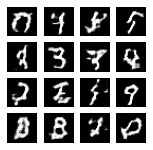

1500 [Discriminator loss: 0.543759, acc: 0.695312, Adversarial loss: 1.022379, acc: 0.234375]


In [ ]:
train_gan(G, D, A)